In [53]:
import glob
import os
from lsst import afw
print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry
import numpy

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std
import numpy

from scipy import signal
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt

%matplotlib inline

20.0.0-4-gde602ef96+1


In [54]:
# setting up file paths we're looking at, for QE flats

# NOW looking at Raft 14, CCD 21, run 10928 (must be a good run) !!!

superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-014/RTM-014-10928-S21_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-014/RTM-014-10928-S21_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-014/10928/qe_raft_acq/v0/84753/S21/*_lambda_flat_*")

qeflatpath.sort()

In [55]:
wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])
print(wls)

[ 319.994  324.969  349.982  374.975  400.019  424.965  450.035  475.003
  500.018  525.002  550.029  575.023  599.982  619.997  624.979  650.012
  675.004  700.03   725.012  750.022  774.987  799.976  824.988  850.022
  869.967  875.002  899.999  919.999  925.012  949.965  975.002  999.976
 1025.028 1050.014 1075.002 1099.99 ]


In [56]:
!wget -O filter_curves.fits https://www.sdss.org/wp-content/uploads/2017/04/filter_curves.fits

--2020-07-10 20:04:50--  https://www.sdss.org/wp-content/uploads/2017/04/filter_curves.fits
Resolving www.sdss.org (www.sdss.org)... 128.220.233.141
Connecting to www.sdss.org (www.sdss.org)|128.220.233.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34560 (34K) [image/fits]
Saving to: ‘filter_curves.fits’

100%[======================================>] 34,560      --.-K/s   in 0.1s    

2020-07-10 20:04:51 (259 KB/s) - ‘filter_curves.fits’ saved [34560/34560]



Text(0.5, 0, 'Angstrom')

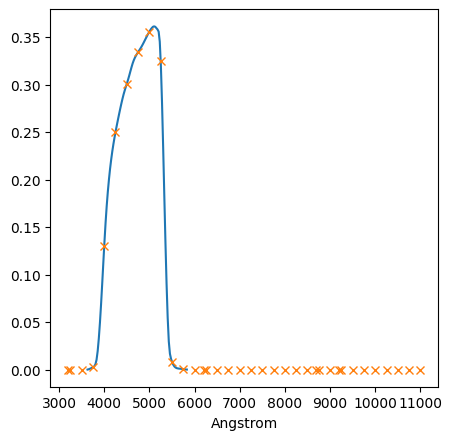

In [57]:
fig, axs = pylab.subplots(figsize=(5,5),dpi=100) 

# [('wavelength', '>f4'), ('respt', '>f4'), ('resbig', '>f4'), ('resnoa', '>f4'), ('xatm', '>f4')]

sdssfilter = fits.open("filter_curves.fits")

# look a filter 2 again, blue
pylab.plot(sdssfilter[2].data["wavelength"],sdssfilter[2].data["respt"])
weights = numpy.interp(wls*10,sdssfilter[2].data["wavelength"],sdssfilter[2].data["respt"])
pylab.plot(wls*10,weights,"x")
pylab.xlabel("Angstrom")

In [58]:
# load other flat data
'''
superbiaspath_13 = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-013/RTM-013-10982-S21_superbias_normal.fits"
superdarkpath_13 = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-013/RTM-013-10982-S21_superdark_normal.fits"
qeflatpath_13 = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/*_lambda_flat_*")
qeflatpath_13.sort()

wls_13 = numpy.array([ get_ccd_from_id(None, aqeflatpath_13, []).md.md["MONOWL"] for aqeflatpath_13 in qeflatpath_13 ])

fig, axs = pylab.subplots(figsize=(5,5),dpi=300) 

# [('wavelength', '>f4'), ('respt', '>f4'), ('resbig', '>f4'), ('resnoa', '>f4'), ('xatm', '>f4')]

sdssfilter = fits.open("filter_curves.fits")
# look a filter 2 again, blue
pylab.plot(sdssfilter[2].data["wavelength"],sdssfilter[2].data["respt"])
weights = numpy.interp(wls_13*10,sdssfilter[2].data["wavelength"],sdssfilter[2].data["respt"])
weights = numpy.interp(wls*10,sdssfilter[2].data["wavelength"],sdssfilter[2].data["respt"])

pylab.plot(wls*10,weights,"x")
pylab.plot(wls_13*10,weights,"x")
pylab.xlabel("Angstrom")

'''

'\nsuperbiaspath_13 = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-013/RTM-013-10982-S21_superbias_normal.fits"\nsuperdarkpath_13 = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-013/RTM-013-10982-S21_superdark_normal.fits"\nqeflatpath_13 = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/*_lambda_flat_*")\nqeflatpath_13.sort()\n\nwls_13 = numpy.array([ get_ccd_from_id(None, aqeflatpath_13, []).md.md["MONOWL"] for aqeflatpath_13 in qeflatpath_13 ])\n\nfig, axs = pylab.subplots(figsize=(5,5),dpi=300) \n\n# [(\'wavelength\', \'>f4\'), (\'respt\', \'>f4\'), (\'resbig\', \'>f4\'), (\'resnoa\', \'>f4\'), (\'xatm\', \'>f4\')]\n\nsdssfilter = fits.open("filter_curves.fits")\n# look a filter 2 again, blue\npylab.plot(sdssfilter[2].data["wavelength"],sdssfilter[2].data["respt"])\nweights = numpy.interp(wls_13*10,sdssfilter[2].data["wavelength"],sdssfilter[2].data["respt"])\nweights = nump

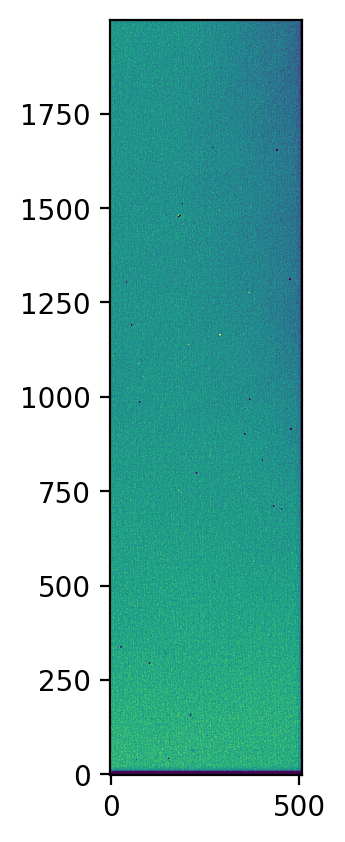

In [59]:

superdark = get_ccd_from_id(None, superdarkpath, [])     # load superdark, (but haven't used anywhere)
superbias = get_ccd_from_id(None, superbiaspath, [])     # load superbias

arr = []        # defines an empty array for storing new combined flat
ch = 1          # defines a channel we'll explore in the following:
for i, aqeflatpath in enumerate(qeflatpath):
    aqeflat = get_ccd_from_id(None, aqeflatpath, [], bias_frame=superbias)
    
    img = aqeflat.unbiased_and_trimmed_image(ch).getImage().array
    img = img/img.mean()     # this will normalize your image
    
    arr.append(img*weights[i])
    

# Let's see how the Combined flat looks 
# dpi changes size of image

fig, axs = pylab.subplots(figsize=(5,5),dpi=200) 
img = numpy.sum(arr,axis=0)/numpy.sum(weights)
mean = img.mean()
std = mad_std(img)
N = 3
pylab.imshow(img,vmin=mean-N*std,vmax=mean+N*std,origin="lower")

In [60]:
# FIND NEW CCOB SYNTHESIZED R & B FLATS



# CCOB flats from testing_making_flat_from_lambda

"""
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits"
ccob_red = get_ccd_from_id(None, fname, [])
print ( mad_std(get_data_as_read(ccob_red,ch,["imaging"])["imaging"]))
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_uv_-211.815_-0.395.fits"
ccob_blue = get_ccd_from_id(None, fname, [])
print ( mad_std(get_data_as_read(ccob_blue,ch,["imaging"])["imaging"]))
"""

# new CCOB flats produced a small and big number and then error in next cell ...
"""
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R12_S02_red_-169.365_41.985.fits"
ccob_red = get_ccd_from_id(None, fname, [])
print ( mad_std(get_data_as_read(ccob_red,ch,["imaging"])["imaging"]))
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R12_S02_uv_-169.365_41.985.fits"
ccob_blue = get_ccd_from_id(None, fname, [])
print ( mad_std(get_data_as_read(ccob_blue,ch,["imaging"])["imaging"]))
"""

# another set of new CCOB flats worked,  using these for rest of file
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R20_S21_red_52.885_-264.175.fits"
ccob_red = get_ccd_from_id(None, fname, [])
print ( mad_std(get_data_as_read(ccob_red,ch,["imaging"])["imaging"]))
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R20_S21_uv_52.885_-264.175.fits"
ccob_blue = get_ccd_from_id(None, fname, [])
print ( mad_std(get_data_as_read(ccob_blue,ch,["imaging"])["imaging"]))

# normalize flat 
red = get_data_as_read(ccob_red,ch,["imaging"])["imaging"]
blue = get_data_as_read(ccob_blue,ch,["imaging"])["imaging"]

# changed this normalization to blue!!
normedimg = img/img.mean()*blue.mean()


464.05449439225345
376.5809635004229


312.2209695384981
376.5809635004229
0.007314927154518149


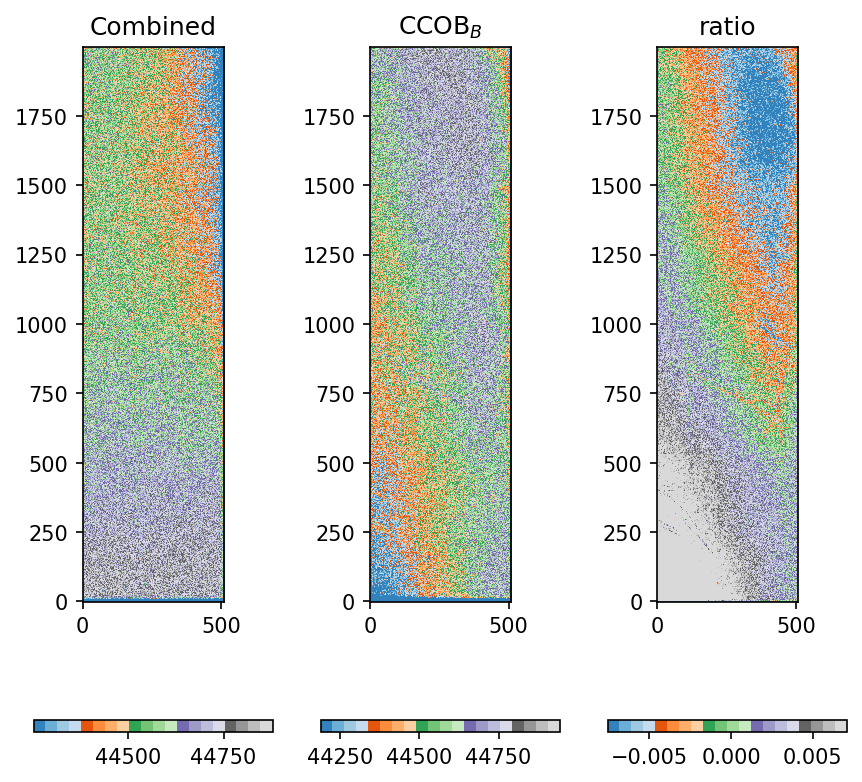

In [61]:
# change so CCOB B is displayed intstead of R

fig, axs = pylab.subplots(1,3,figsize=(7,7),dpi=150) 
for ax, animg, label in zip(axs,[normedimg, blue, (normedimg-blue)/blue], ["Combined",r"CCOB$_{B}$","ratio"]):
    mean = numpy.median(animg)
    std = mad_std(animg)
    N = 1
    ax.set_title(label)
    im = ax.imshow(animg,vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))
    fig.colorbar( im, ax=ax, orientation="horizontal")
    print(std)

536.7541258332723
464.05449439225345
0.006622223888850444


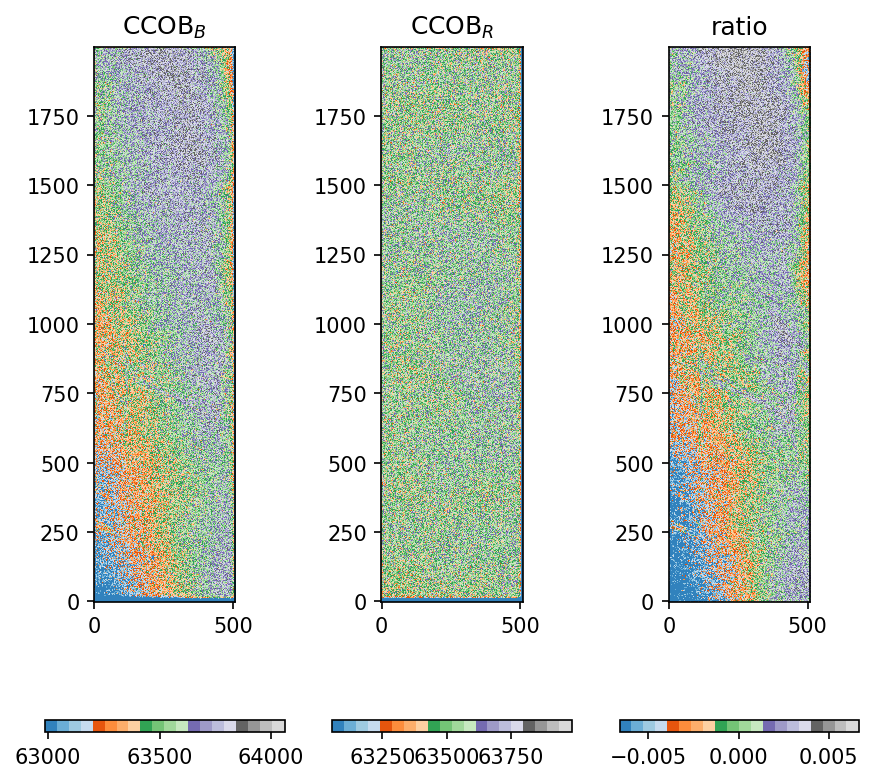

In [62]:
# to compare CCOB B vs. CCOB R vs. ratio ... same as in last notebook


fig, axs = pylab.subplots(1,3,figsize=(7,7),dpi=150)
normedblue = blue/blue.mean()*red.mean()
for ax, animg, label in zip(axs,[normedblue, red, (normedblue-red)/red], [r"CCOB$_{B}$",r"CCOB$_{R}$","ratio"]):
    mean = numpy.median(animg)
    std = mad_std(animg)
    N = 1
    ax.set_title(label)
    im = ax.imshow(animg,vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))
    fig.colorbar( im, ax=ax, orientation="horizontal")
    print(std)


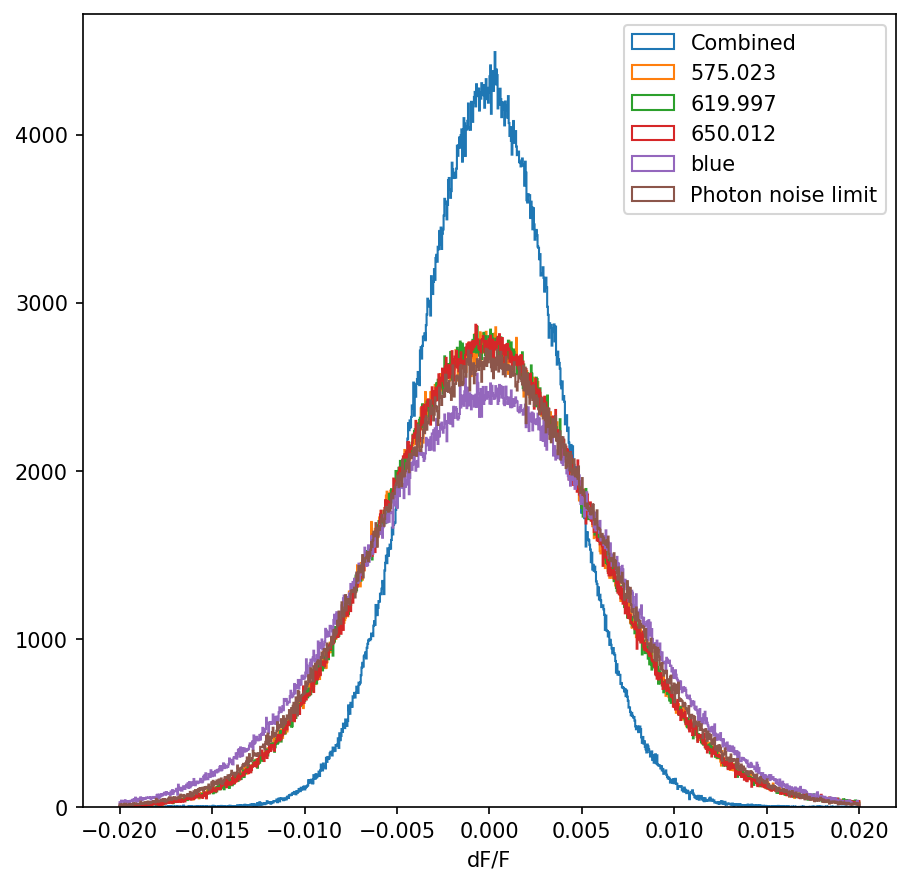

In [63]:
# create (uncertainty? fluctuation?) histogram

flatpairs = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/flat_pair_raft_acq/v0/85183/S21/ITL-3800C-318_flat_*_flat?*.fits")
flatpairs.sort()
for i, aflatpair in enumerate(flatpairs):
    aqeflat = get_ccd_from_id(None, aflatpair, [], bias_frame=superbias)
    img = aqeflat.unbiased_and_trimmed_image(ch).getImage().array
    #print("{:02d}   {}   {:05f}".format(i, os.path.basename(aflatpair), img.mean()))
    
    
    
fig, axs = pylab.subplots(1,1,figsize=(7,7),dpi=150)

def getonewl( num ):
    fname = qeflatpath[num]
    ccd_particular = get_ccd_from_id(None, fname, [])
    particular = get_data_as_read(ccd_particular,ch,["imaging"])["imaging"]
    normedparticular = particular/particular.mean()*red.mean()
    return normedparticular.flatten(),  ccd_particular.md.md["MONOWL"]

for anarray, label in [
            ( normedimg.flatten(), "Combined" ),
            getonewl(11),
            getonewl(13),
            getonewl(15),
            ( normedblue.flatten(), "blue" ),
#            ( red.mean(), r"$\langle {\rm red}\rangle$-red" )    
    ]:
    arr = (anarray-red.flatten())/red.flatten()
    pylab.hist(arr-numpy.median(arr),
               bins=1000,range=(-0.02,0.02),histtype="step",label=label)
#30,31   #20k
#52,53   #60k
#76,77
a=get_ccd_from_id(None, flatpairs[30], [], bias_frame=superbias).unbiased_and_trimmed_image(ch).getImage().array # one of flat pairs which have almost same flux level as R. (~20k)
b=get_ccd_from_id(None, flatpairs[31], [], bias_frame=superbias).unbiased_and_trimmed_image(ch).getImage().array
rand = ( a-b ).flatten()/(b.flatten())/numpy.sqrt(2)
pylab.hist(
    rand-numpy.median(rand),
    bins=1000,range=(-0.02,0.02),histtype="step",label="Photon noise limit"
)
pylab.xlabel("dF/F")
pylab.legend()

312.2209695384981
376.5809635004229
0.007314927154518149


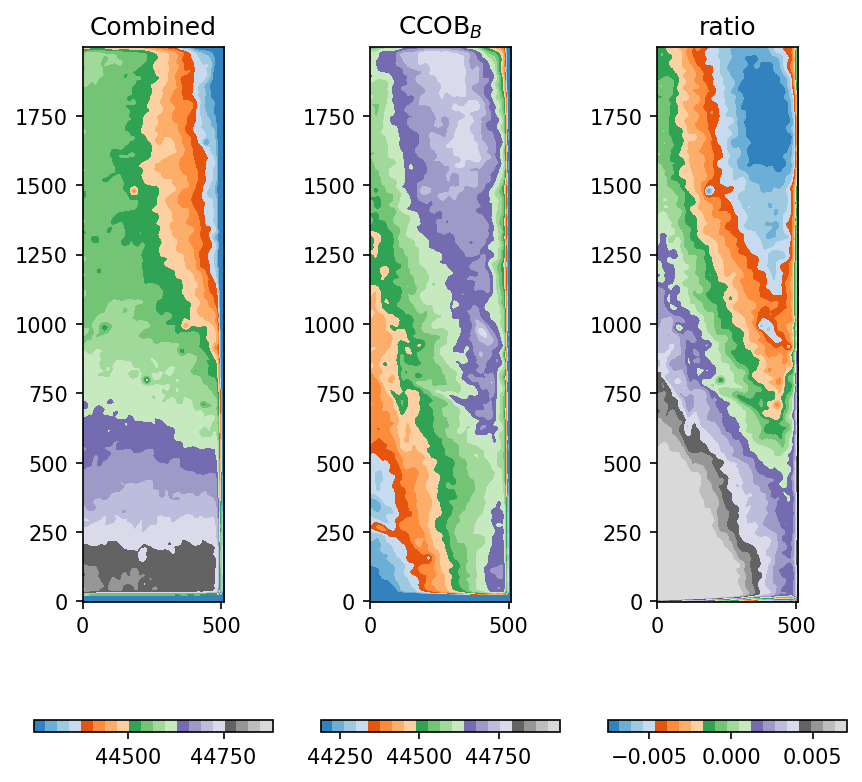

In [64]:
# comparing against CCOBb

from scipy.ndimage import gaussian_filter

sigma=10
N = 1

fig, axs = pylab.subplots(1,3,figsize=(7,7),dpi=150) 
for ax, animg, label in zip(axs,[normedimg, blue, (normedimg-blue)/blue], ["Combined",r"CCOB$_{B}$","ratio"]):
    mean = numpy.median(animg)
    std = mad_std(animg)
    ax.set_title(label)
    im = ax.imshow(gaussian_filter(animg,sigma=sigma),vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))
    fig.colorbar( im, ax=ax, orientation="horizontal")
    print(std)

312.2209695384981
464.05449439225345
0.0038008369635960577


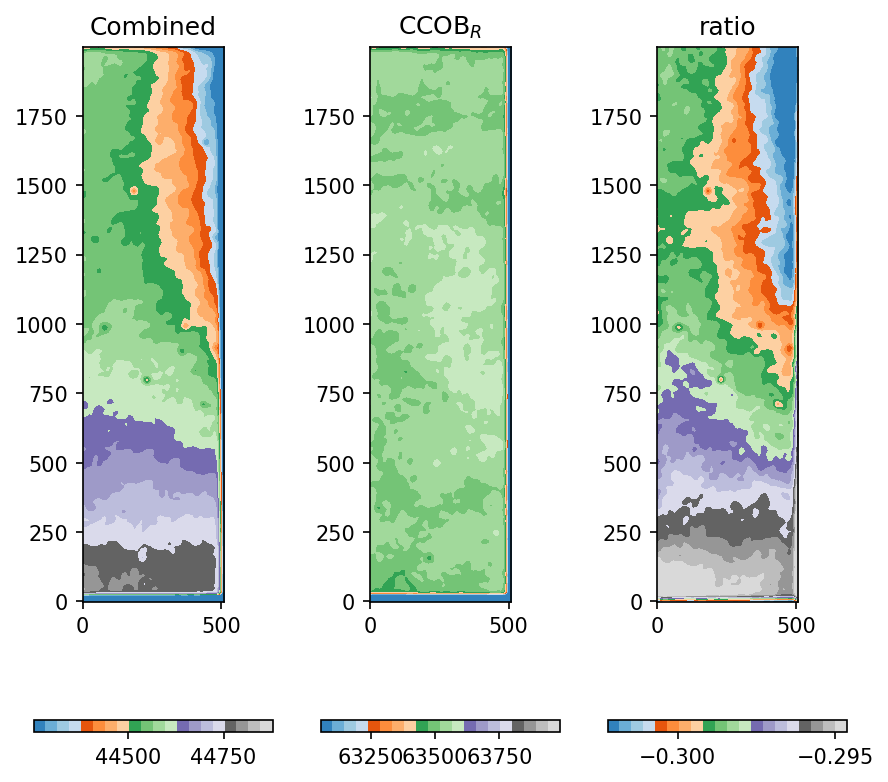

In [65]:
# comparing against CCOBr

sigma=10
N = 1

fig, axs = pylab.subplots(1,3,figsize=(7,7),dpi=150) 
for ax, animg, label in zip(axs,[normedimg, red, (normedimg-red)/red], ["Combined",r"CCOB$_{R}$","ratio"]):
    mean = numpy.median(animg)
    std = mad_std(animg)
    ax.set_title(label)
    im = ax.imshow(gaussian_filter(animg,sigma=sigma),vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))
    fig.colorbar( im, ax=ax, orientation="horizontal")
    print(std)

0.28%
0.15%
0.12%
0.12%
0.3%
0.3%


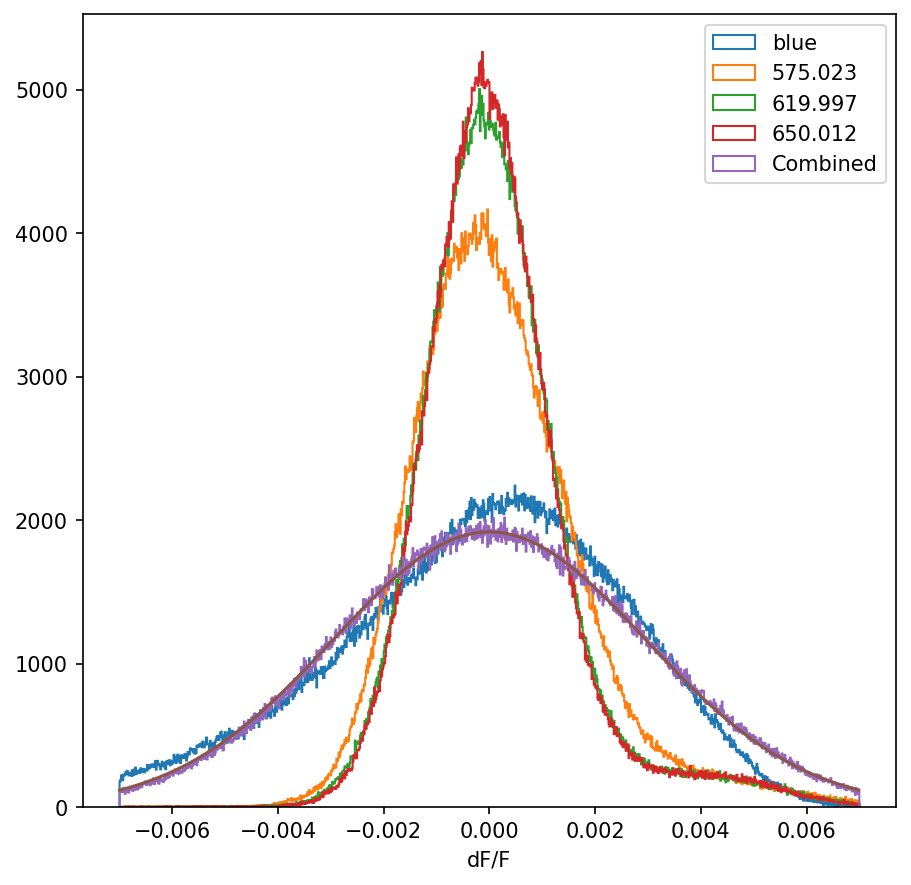

In [66]:

from scipy import signal


fig, axs = pylab.subplots(1,1,figsize=(7,7),dpi=150)

range = (-0.007,0.007)
nbins = 1000
for anarray, label in [
            ( normedblue.flatten(), "blue" ),
#            ( normedimg.flatten(), "Combined" ),
            getonewl(11),
            getonewl(13),
            getonewl(15),
            ( normedimg.flatten(), "Combined" ),    
#            ( red.mean(), r"$\langle {\rm red}\rangle$-red" )    
    ]:
    arr = gaussian_filter(anarray-red.flatten(),sigma=sigma)/red.flatten()
    s = mad_std(arr)
    print("{:.2}%".format(s*100))    
    pylab.hist(arr-numpy.median(arr),
               bins=nbins,range=range,histtype="step",label=label)
dx= (range[-1]-range[0])/nbins
x = numpy.arange(*range,dx)
s = mad_std(arr)
y = numpy.exp(-x**2/(2*s**2))/numpy.sqrt(2*numpy.pi*s**2)*dx*arr.shape[0]
print("{:.2}%".format(s*100))
pylab.plot(x,y)
pylab.xlabel("dF/F")
pylab.legend()